In [3]:
from UDP_profiler import UDPProfilerJobPreparer
import openeo
from job_management import MultiBackendJobManager
import pandas as pd

# Define your constants and parameters
process_graph_path = 'NDWI.json'
spatial_range = [10000, 20000, 40000] #km extend
temporal_range = [3, 6, 12] #months
repetition = 3
output_file_prefix = "UDP_cost_profile"

# Initialize the JobPreparer
job_preparer = UDPProfilerJobPreparer(process_graph_path)

# Prepare the jobs DataFrame
jobs_df = job_preparer.prepare_jobs_df(temporal_range, spatial_range, repetition=repetition)

# Generate an output filename
output_file = job_preparer.generate_output_filename(output_file_prefix, job_preparer.process_graph["id"])

manager = MultiBackendJobManager(max_running_duration = 3 * 60 * 60)  # Test with a 1-minute limit

# Authenticate and add the backend
connection = openeo.connect(url="openeo.dataspace.copernicus.eu").authenticate_oidc()
manager.add_backend("cdse", connection=connection, parallel_jobs=10)

# Define the start_job function
def start_job(row: pd.Series, connection: openeo.Connection, **kwargs) -> openeo.BatchJob:
    """Start a new job using the specified row and connection."""
    process_graph_path = row["process_graph_path"]
    spatial_extent = row["spatial_extent"]
    temporal_extent = row["temporal_extent"]

    cube = connection.datacube_from_json(
        process_graph_path,
        parameters={"spatial_extent": spatial_extent, "temporal_extent": temporal_extent}
    )
    
    return cube.create_job(
        title='Process Graph - Benchmark',
        format="netcdf"
    )

# Run the jobs
manager.run_jobs(df=jobs_df, start_job=start_job, output_file=output_file)




Authenticated using refresh token.


In [4]:
# Add cost information

import pandas as pd

# Define the get_job_cost_info function
def get_job_cost_info(connection, job_id):
    """Retrieve job cost information from the connection."""
    try:
        job = connection.job(job_id).describe_job()
        return float(job["costs"])
    except:
        return "costs"
    
# Load your CSV file into a DataFrame
df = pd.read_csv(output_file)

# Apply the get_job_cost_info function to each row
df['job_cost'] = df.apply(lambda row: get_job_cost_info(connection, row['id']), axis=1)

# Save the updated DataFrame back to a CSV file if needed
df.to_csv(output_file, index=False)

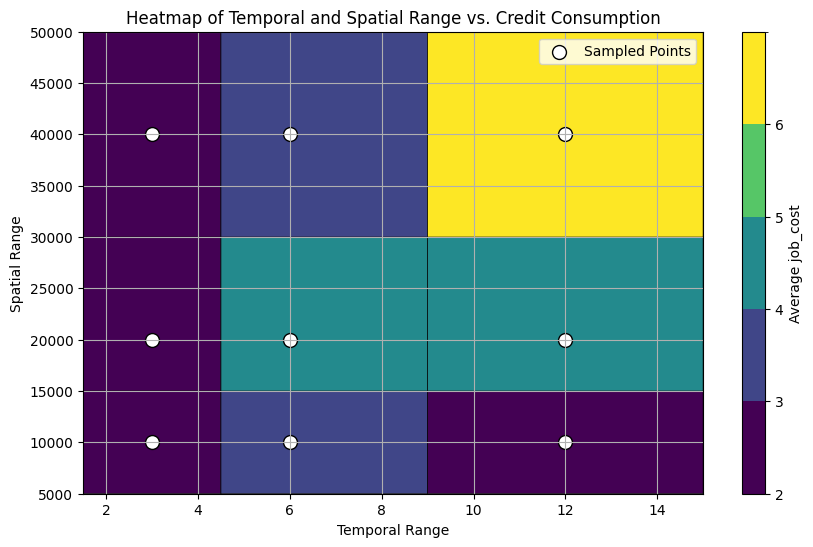

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

# Read the data
df = pd.read_csv(output_file)
output_modality = 'job_cost'
df_filtered = df[df[output_modality].notna() & (df[output_modality] != '')]


# Find all unique combinations of spatial and temporal range
unique_combinations = df_filtered[['spatial_range', 'temporal_range']].drop_duplicates()

# Calculate the average of the output modality for each unique combination
average_modality = df_filtered.groupby(['spatial_range', 'temporal_range'])[output_modality].mean().reset_index()

# Create a grid for spatial and temporal ranges
spatial_range = sorted(average_modality['spatial_range'].unique())
temporal_range = sorted(average_modality['temporal_range'].unique())

# Create a 2D grid for job_cost values
job_cost_grid = np.full((len(spatial_range), len(temporal_range)), np.nan)

# Fill the grid with average job_cost values
for _, row in average_modality.iterrows():
    i = spatial_range.index(row['spatial_range'])
    j = temporal_range.index(row['temporal_range'])
    job_cost_grid[i, j] = row[output_modality]

# Define the colormap and normalization
cmap = plt.get_cmap('viridis', 20)  # 10 discrete colors
norm = BoundaryNorm(boundaries=range(int(average_modality[output_modality].min()), int(average_modality[output_modality].max()) + 2), ncolors=cmap.N, clip=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
pc = plt.pcolor(temporal_range, spatial_range, job_cost_grid, cmap=cmap, norm=norm, edgecolors='k', linewidths=0.5)

# Add colorbar
cbar = plt.colorbar(pc, ticks=range(int(average_modality[output_modality].min()), int(average_modality[output_modality].max()) + 1))
cbar.set_label(f'Average {output_modality}')
cbar.set_ticks(range(int(average_modality[output_modality].min()), int(average_modality[output_modality].max()) + 1))

# Overlay scatter points
plt.scatter(average_modality['temporal_range'], average_modality['spatial_range'], c='white', edgecolor='black', s=100, label='Sampled Points')

# Labeling the axes and title
plt.xlabel('Temporal Range')
plt.ylabel('Spatial Range')
plt.title('Heatmap of Temporal and Spatial Range vs. Credit Consumption')
plt.grid(True)
plt.legend()

plt.show()